In [1]:
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense
from keras.applications import ResNet50
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss, top_k_accuracy_score

### Extract and Load Data

In [17]:
annotation_file_path = "../data/flickr_logos_27_dataset_training_set_annotation.txt"
annotationDF = pd.read_csv(annotation_file_path, 
                      sep="\s+", 
                      header=None, 
                      names=["image", "logo", "subset", "x1", "y1", "x2", "y2"])

<Figure size 1500x1000 with 0 Axes>

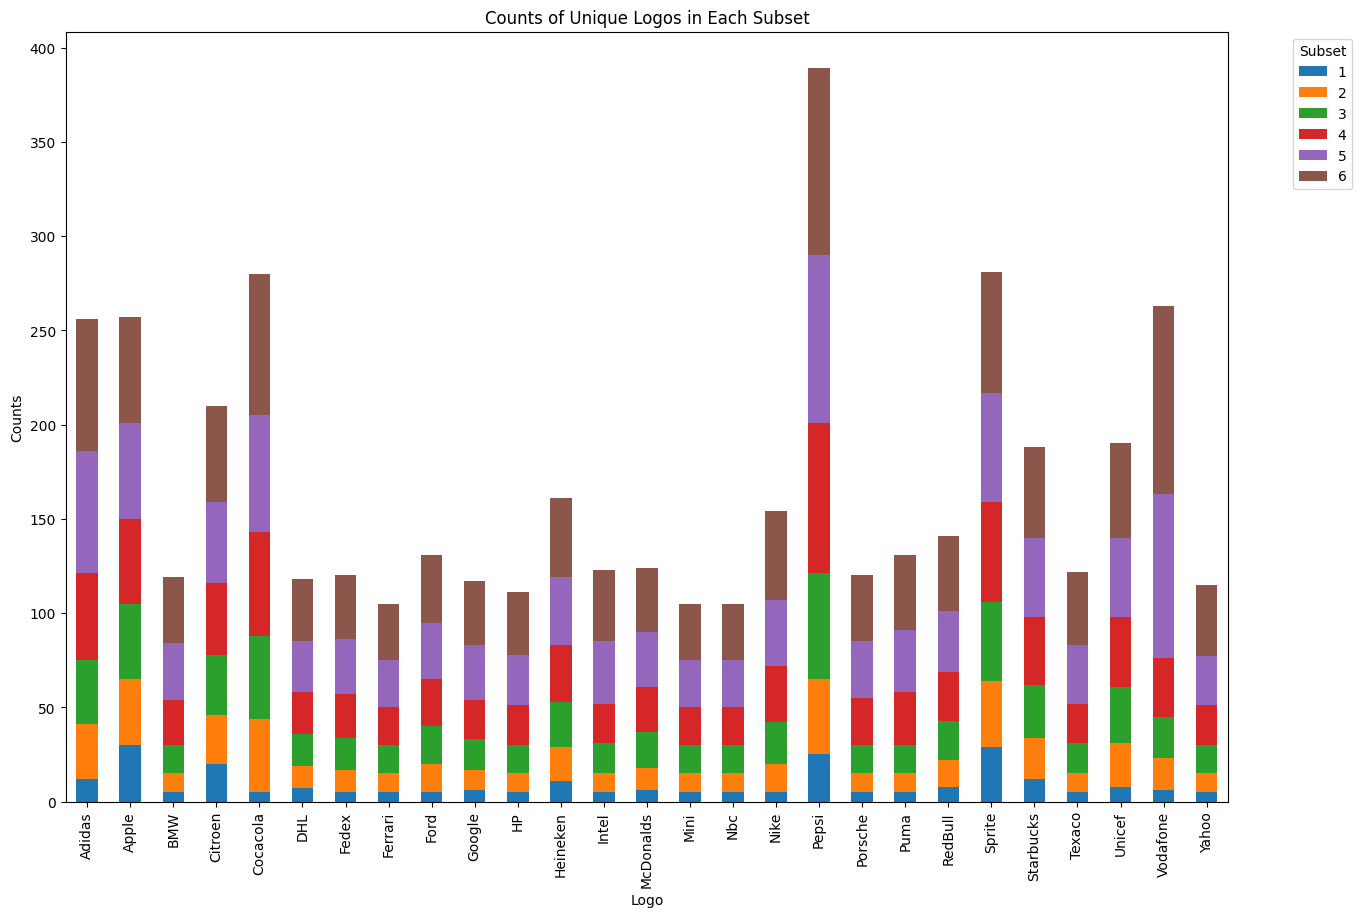

In [18]:
groupedDF = annotationDF.groupby(['logo', 'subset']).size().unstack(fill_value=0)

plt.figure(figsize=(15, 10))
groupedDF.plot(kind='bar', stacked=True, figsize=(15, 10))
plt.title('Counts of Unique Logos in Each Subset')
plt.xlabel('Logo')
plt.ylabel('Counts')
plt.legend(title='Subset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Before Preprocessing

In [21]:
images_dir = "../data/flickr_logos_27_dataset_images"
sample_images = []
sample_image_file = []

for image in os.listdir(images_dir):
    image_path = os.path.join(images_dir, image)
    img = cv2.imread(image_path)
    sample_images.append(img)
    sample_image_file.append(image)

# Display the number of images and labels
print("Total images: {}".format(len(sample_images)))
print("Total labels: {}".format(len(sample_image_file)))

Total images: 1079
Total labels: 1079


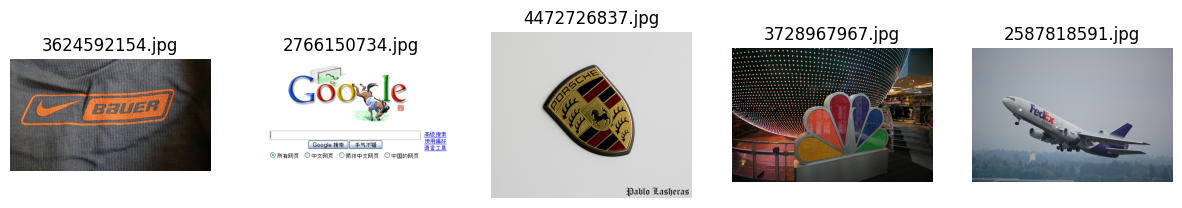

In [22]:
plt.figure(figsize=(15, 10))
random_indices = random.sample(range(len(sample_images)), 5)
for i, index in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(sample_images[index], cv2.COLOR_BGR2RGB))
    plt.title(sample_image_file[index])
    plt.axis('off')
plt.show()

### After Cropping

In [23]:
# Initialize lists to hold the cropped images and their labels
sample2 = []
sample_image2 = []

# Loop through the images in the directory
for image in os.listdir(images_dir):
    image_path = os.path.join(images_dir, image)
    img = cv2.imread(image_path)
    
    if img is not None:
        # Get the annotations for this image
        image_annotations = annotationDF[annotationDF['image'] == image]
        
        # Loop through the annotations and crop the image accordingly
        for _, row in image_annotations.iterrows():
            x1, y1, x2, y2, logo = row['x1'], row['y1'], row['x2'], row['y2'], row['logo']
            cropped_img = img[y1:y2, x1:x2]
            
            sample2.append(cropped_img)
            sample_image2.append(logo)

# Display the number of images and labels
print("Total images: {}".format(len(sample2)))
print("Total labels: {}".format(len(sample_image2)))

Total images: 4536
Total labels: 4536


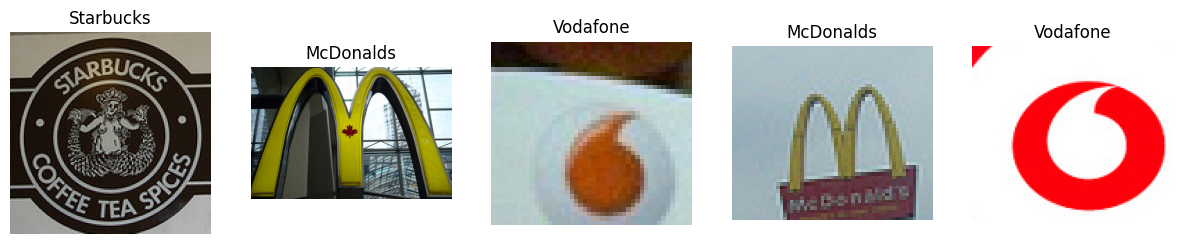

In [24]:
plt.figure(figsize=(15, 10))
random_indices = random.sample(range(len(sample2)), 5)
for i, index in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(sample2[index], cv2.COLOR_BGR2RGB))
    plt.title(sample_image2[index])
    plt.axis('off')
plt.show()

### After Cropping Adding PreProcessing

In [25]:
# Initialize lists to hold the cropped images and their labels
X = []
y = []

# Preprocessing functions
def preprocess_image(img):
#     try:
    img = cv2.resize(img, (224, 224))
    return tf.keras.applications.resnet.preprocess_input(img)

# Loop through the images in the directory
for image in os.listdir(images_dir):
    image_path = os.path.join(images_dir, image)
    img = cv2.imread(image_path)

    if img is not None:
        # Get the annotations for this image
        image_annotations = annotationDF[annotationDF['image'] == image]

        # Loop through the annotations and crop the image accordingly
        for _, row in image_annotations.iterrows():
            x1, y1, x2, y2, logo = row['x1'], row['y1'], row['x2'], row['y2'], row['logo']

            if x1 < 0 or y1 < 0 or x2 > img.shape[1] or y2 > img.shape[0]:
                print(f"Invalid coordinates for image {image}: ({x1}, {y1}, {x2}, {y2})")
                continue

            cropped_img = img[y1:y2, x1:x2]

            if cropped_img.size == 0:
                print(f"Cropped image: {image} is empty for coordinates: ({x1}, {y1}, {x2}, {y2})")
                continue

            processed_img = preprocess_image(cropped_img)
            
            if processed_img is None:
                continue

            X.append(processed_img)
            y.append(logo)

try:
    X = np.array(X, dtype=np.float32)
    y = np.array(y)
except ValueError as e:
    print(f"Error converting lists to arrays: {e}")

# Display the number of images and labels
print("Total images: {}".format(len(X)))
print("Total labels: {}".format(len(y)))

Cropped image: 2662264721.jpg is empty for coordinates: (3, 197, 3, 197)
Cropped image: 2662264721.jpg is empty for coordinates: (3, 197, 3, 197)
Cropped image: 2662264721.jpg is empty for coordinates: (3, 197, 3, 197)
Cropped image: 2662264721.jpg is empty for coordinates: (3, 197, 3, 197)
Cropped image: 2662264721.jpg is empty for coordinates: (3, 197, 3, 197)
Total images: 4531
Total labels: 4531


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-108.779..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..143.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-112.68..122.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.68..59.060997].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-99.779..151.061].


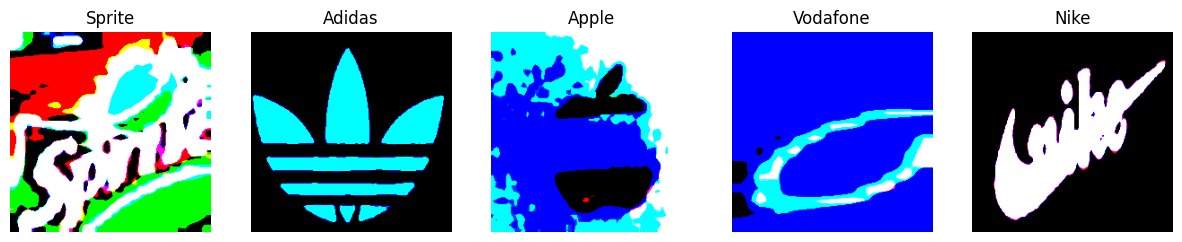

In [26]:
plt.figure(figsize=(15, 10))
random_indices = random.sample(range(len(X)), 5)
for i, index in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(X[index], cv2.COLOR_BGR2RGB))
    plt.title(y[index])
    plt.axis('off')
plt.show()

### One Hot Encoding & Splitting Train and Test Data

In [27]:
unique_classes = np.unique(y)

def custom_one_hot_encode(labels, classes):
    n_classes = len(classes)
    n_labels = len(labels)
    one_hot = np.zeros((n_labels, n_classes))
    for i, label in enumerate(labels):
        one_hot[i, np.where(classes == label)[0]] = 1
    return one_hot

# Use the custom function
y_encoded = custom_one_hot_encode(y, unique_classes)

In [11]:
np.save('class_order.npy', unique_classes)

In [28]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# Display the number of images and labels
print("Total images: {}".format(len(X)))
print("Total labels: {}".format(len(y)))
print("Training images: {}".format(len(X_train)))
print("Validation images: {}".format(len(X_val)))
print("Testing images: {}".format(len(X_test)))

Total images: 4531
Total labels: 4531
Training images: 2718
Validation images: 906
Testing images: 907


### Image Augmentation on Trainining Data

In [13]:
aug_train_images = []
aug_train_labels = []

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

for index, train_img in enumerate(X_train):
    add_logo = y_train[index]

    expanded_img = np.expand_dims(train_img, axis=0)

    aug_iter = datagen.flow(expanded_img, batch_size=1)
    aug_images = [next(aug_iter)[0].astype(np.float32)]

    for aug_img in aug_images:
        aug_train_images.append(aug_img)
        aug_train_labels.append(add_logo)

aug_train_images = np.array(aug_train_images, dtype=np.float32)
aug_train_labels = np.array(aug_train_labels)

X_train = np.concatenate((X_train, aug_train_images), axis=0)
y_train = np.concatenate((y_train, aug_train_labels), axis=0)

print("Total training images after augmentation: {}".format(len(X_train)))
print("Total training labels after augmentation: {}".format(len(y_train)))

Total training images after augmentation: 5436
Total training labels after augmentation: 5436


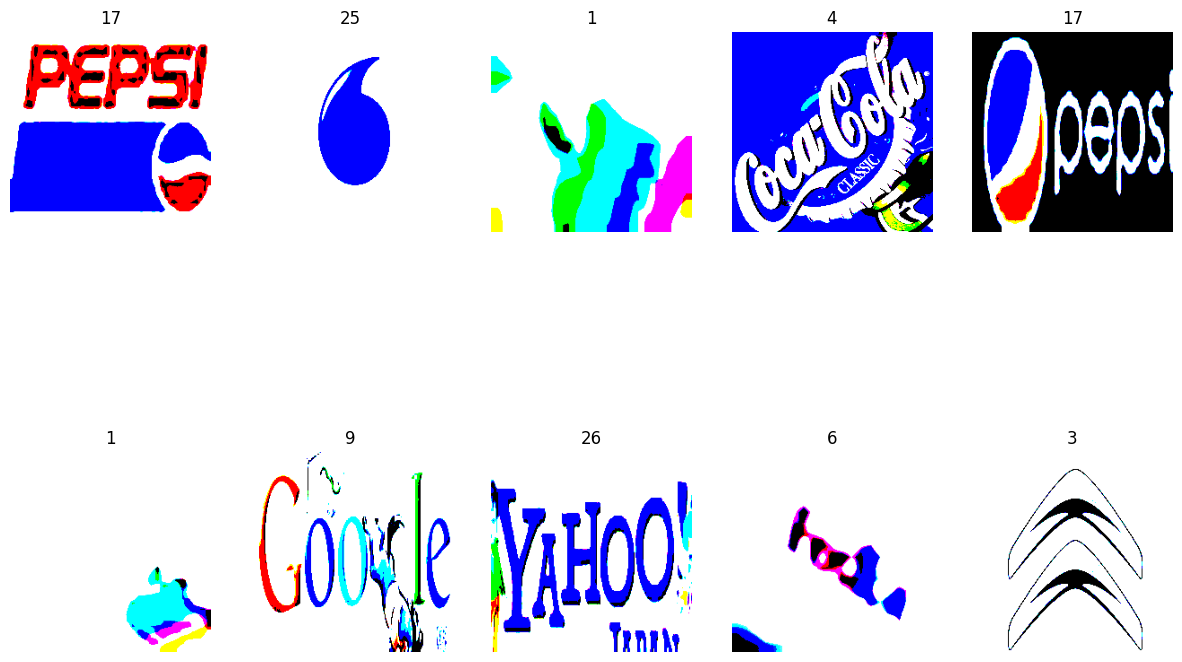

In [20]:
plt.figure(figsize=(15, 10))
random_indices = random.sample(range(len(X_train)), 10)
for i, index in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(X_train[index], cv2.COLOR_BGR2RGB))
    plt.title(np.argmax(y_train[index]))
    plt.axis('off')
plt.show()

In [29]:
# Display the number of images and labels
print("Total images: {}".format(len(X)))
print("Total labels: {}".format(len(y)))
print("Training images: {}".format(len(X_train)))
print("Training labels: {}".format(len(y_train)))
print("Validation images: {}".format(len(X_val)))
print("Validation labels: {}".format(len(y_val)))
print("Testing images: {}".format(len(X_test)))
print("Testing labels: {}".format(len(y_test)))

Total images: 4531
Total labels: 4531
Training images: 2718
Training labels: 2718
Validation images: 906
Validation labels: 906
Testing images: 907
Testing labels: 907


### ResNet Modelling

In [31]:
base_layer = ResNet50(include_top=False, input_shape=(224, 224, 3), pooling='avg')

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_layer(inputs)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = Dense(len(y_train[0]), activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(loss='categorical_crossentropy', optimizer ='adam', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', patience = 1, verbose = 1, factor = 0.25, mode="min")
model.summary()

In [37]:
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=6,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr]
)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Epoch 1/4
43/43 ━━━━━━━━━━━━━━━━━━━━ 479s 11s/step - accuracy: 0.8931 - loss: 0.4620 - val_accuracy: 0.0684 - val_loss: 286.9829 - learning_rate: 0.0010
Epoch 2/4
43/43 ━━━━━━━━━━━━━━━━━━━━ 503s 12s/step - accuracy: 0.9683 - loss: 0.1252 - val_accuracy: 0.4934 - val_loss: 3.7095 - learning_rate: 0.0010
Epoch 3/4
43/43 ━━━━━━━━━━━━━━━━━━━━ 505s 12s/step - accuracy: 0.9941 - loss: 0.0249 - val_accuracy: 0.6512 - val_loss: 3.0640 - learning_rate: 0.0010
Epoch 4/4
43/43 ━━━━━━━━━━━━━━━━━━━━ 554s 13s/step - accuracy: 0.9969 - loss: 0.0178 - val_accuracy: 0.9117 - val_loss: 0.3251 - learning_rate: 0.0010
29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 914ms/step - accuracy: 0.9155 - loss: 0.3215
Test Accuracy: 89.97%


In [ ]:
# Predict on test data
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = np.mean(y_pred_classes == y_test)
print("Accuracy on test set: {:.2f}".format(accuracy))

# Calculate precision
precision = precision_score(y_test, y_pred_classes, average='weighted')
print("Precision on test set: {:.2f}".format(precision))

# Calculate recall
recall = recall_score(y_test, y_pred_classes, average='weighted')
print("Recall on test set: {:.2f}".format(recall))

# Calculate F1 score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print("F1 Score on test set: {:.2f}".format(f1))

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_classes, multi_class='ovr')
print("ROC-AUC on test set: {:.2f}".format(roc_auc))

# Calculate log loss
logloss = log_loss(y_test, y_pred_classes)
print("Log Loss on test set: {:.2f}".format(logloss))

In [38]:
model.save('resnet.keras')